# Grad-CAM Analysis

Functions import

In [3]:
import shutil
import random
import os
import cv2
import pathlib
import numpy as np
import pandas as pd
import pathlib

import tensorflow as tf
import matplotlib.pyplot as plt
from numpy.random import seed
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
import tensorflow as tf
#from keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.regularizers import l1, l2, l1_l2

# Set random seed for reproducibility
seed_train_validation = 42
tf.random.set_seed(seed_train_validation)
np.random.seed(seed_train_validation)

Data loading

In [4]:
# Directory paths
train_data_dir = '/kaggle/input/aml-flowers-dataset/train_images_by_class/train_images_by_class'
val_data_dir = '/kaggle/input/aml-flowers-dataset/validation_images_by_class/validation_images_by_class'
test_data_dir = '/kaggle/input/aml-flowers-dataset/test_images_by_class/test_images_by_class'

# CSV file paths
train_csv_path = '/kaggle/input/aml-flowers-dataset/classes_train.csv'
val_csv_path = '/kaggle/input/aml-flowers-dataset/classes_valid.csv'
test_csv_path = '/kaggle/input/aml-flowers-dataset/classes_test.csv'

train_labels = pd.read_csv(train_csv_path)
val_labels = pd.read_csv(val_csv_path)
test_labels = pd.read_csv(test_csv_path)

# Image size
image_size = (224, 224)

# Batch size
batch_size = 64

Grad-CAM for VGG16

553467096/553467096 [==============================] - 3s 0us/step


/tmp/ipykernel_33/3979212717.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


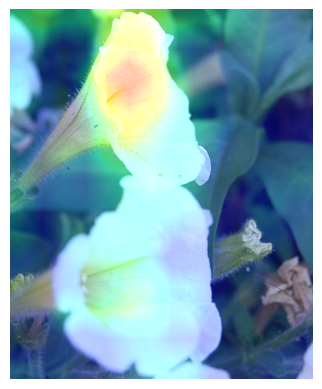

In [5]:
import cv2

def get_img_array(img_path, size):
    img = tf.keras.utils.load_img(img_path, target_size=size)
    array = tf.keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap * 255).astype(np.uint8)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = (jet_colors[heatmap] * 255).astype(np.uint8)

    img = img.astype(np.uint8)
    superimposed_img = cv2.addWeighted(img, 1.0, jet_heatmap, alpha, 0)

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

base_model = VGG16(weights="imagenet")

# Swapping the last fully connected layer with a linear one
last_layer = base_model.get_layer("fc2").output
classifier = tf.keras.models.Model(base_model.input, last_layer)

img_path = "/kaggle/input/aml-flowers-dataset/test_images_by_class/test_images_by_class/51/image_01315.jpg"
img_size = (224, 224)
last_conv_layer_name = "block5_conv3"

img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

heatmap = make_gradcam_heatmap(img_array, classifier, last_conv_layer_name)

display_gradcam(img_path, heatmap)

Grad-CAM for ResNet50

102967424/102967424 [==============================] - 1s 0us/step


/tmp/ipykernel_33/1685076276.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


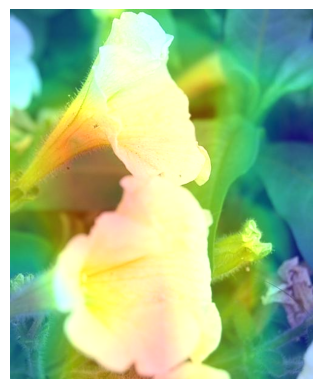

In [6]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import cv2

def get_img_array(img_path, size):
    img = tf.keras.utils.load_img(img_path, target_size=size)
    array = tf.keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap * 255).astype(np.uint8)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = (jet_colors[heatmap] * 255).astype(np.uint8)

    img = img.astype(np.uint8)
    superimposed_img = cv2.addWeighted(img, 1.0, jet_heatmap, alpha, 0)

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

base_model = ResNet50(weights="imagenet")

# Swapping the last average pooling layer with a linear one
last_layer = base_model.get_layer("avg_pool").output
classifier = tf.keras.models.Model(base_model.input, last_layer)

img_path = "/kaggle/input/aml-flowers-dataset/test_images_by_class/test_images_by_class/51/image_01315.jpg"
img_size = (224, 224)
last_conv_layer_name = "conv5_block3_out"

img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

heatmap = make_gradcam_heatmap(img_array, classifier, last_conv_layer_name)

display_gradcam(img_path, heatmap)

Grad-CAM for InceptionV3

96112376/96112376 [==============================] - 1s 0us/step


/tmp/ipykernel_33/2897574852.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


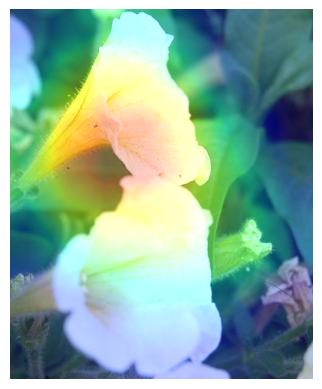

In [7]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_img_array(img_path, size):
    img = tf.keras.utils.load_img(img_path, target_size=size)
    array = tf.keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap * 255).astype(np.uint8)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = (jet_colors[heatmap] * 255).astype(np.uint8)

    img = img.astype(np.uint8)
    superimposed_img = cv2.addWeighted(img, 1.0, jet_heatmap, alpha, 0)

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

base_model = InceptionV3(weights="imagenet")

# Swapping the last average pooling layer with a linear one
last_layer = base_model.get_layer("avg_pool").output
classifier = tf.keras.models.Model(base_model.input, last_layer)

img_path = "/kaggle/input/aml-flowers-dataset/test_images_by_class/test_images_by_class/51/image_01315.jpg"
img_size = (299, 299)
last_conv_layer_name = "mixed10"

img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

heatmap = make_gradcam_heatmap(img_array, classifier, last_conv_layer_name)

display_gradcam(img_path, heatmap)
